# IoT Anomaly Detection

This notebook implements anomaly detection for IoT sensor data using:
1. **Statistical Methods**: Z-score and IQR
2. **LSTM Autoencoder**: Deep learning approach for temporal anomaly detection

We analyze both basic and realistic anomaly datasets.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Using device: cuda


In [2]:
# Load both basic and realistic anomaly datasets
print("Loading datasets...")


# Load normal dataset for training
try:
    df_normal = pd.read_csv('../data/synthetic_sensors_2020.csv')
    print(f"✓ Normal dataset loaded: {df_normal.shape}")
    df_normal['timestamp'] = pd.to_datetime(df_normal['timestamp'])
    df_normal = df_normal.set_index('timestamp')
except FileNotFoundError:
    print("✗ Normal dataset not found")
    df_normal = None

try:
    df_basic = pd.read_csv('../data/synthetic_sensors_basic_anomalies.csv')
    print(f"✓ Basic anomalies dataset loaded: {df_basic.shape}")
except FileNotFoundError:
    print("✗ Basic anomalies dataset not found")
    df_basic = None

try:
    df_realistic = pd.read_csv('../data/synthetic_sensors_realistic_anomalies.csv')
    print(f"✓ Realistic anomalies dataset loaded: {df_realistic.shape}")
except FileNotFoundError:
    print("✗ Realistic anomalies dataset not found")
    df_realistic = None

# Use the realistic dataset as our primary dataset
if df_realistic is not None:
    df = df_realistic.copy()
    dataset_type = "realistic"
elif df_basic is not None:
    df = df_basic.copy()
    dataset_type = "basic"
else:
    raise FileNotFoundError("No anomaly datasets found. Please run generate_anomalies.ipynb first.")

print(f"\nUsing {dataset_type} dataset for analysis")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"\nData range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Loading datasets...
✓ Normal dataset loaded: (259200, 7)
✓ Basic anomalies dataset loaded: (129600, 21)
✓ Realistic anomalies dataset loaded: (129600, 25)

Using realistic dataset for analysis
Dataset shape: (129600, 25)
Columns: ['timestamp', 'temperature', 'humidity', 'fridge_power', 'sensor_window', 'sensor_door', 'sensor_motion', 'is_anomaly_temperature', 'is_anomaly_humidity', 'is_anomaly_fridge_power', 'is_anomaly_sensor_window', 'is_anomaly_sensor_door', 'is_anomaly_sensor_motion', 'is_anomaly_temp_drift', 'is_anomaly_temp_spike', 'is_anomaly_humidity_sudden', 'is_anomaly_fridge_outage', 'is_anomaly_fridge_degradation', 'is_anomaly_window_stuck', 'is_anomaly_window_false', 'is_anomaly_door_stuck', 'is_anomaly_door_false', 'is_anomaly_motion_stuck', 'is_anomaly_motion_false', 'is_anomaly']

Data range: 2025-01-01 00:00:00 to 2025-03-31 23:59:00


In [3]:
# Analyze dataset and anomaly distribution
print("=== DATASET ANALYSIS ===")
print(f"Total records: {len(df):,}")
print(f"Date range: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

# Anomaly statistics
if 'is_anomaly' in df.columns:
    total_anomalies = df['is_anomaly'].sum()
    anomaly_rate = df['is_anomaly'].mean() * 100
    print(f"Total anomalies: {total_anomalies:,} ({anomaly_rate:.2f}%)")
    print(f"Normal records: {len(df) - total_anomalies:,} ({100 - anomaly_rate:.2f}%)")
    
    # Per-sensor anomaly counts
    print("\n=== ANOMALY COUNTS PER SENSOR ===")
    for sensor in ['temperature', 'humidity', 'fridge_power', 'sensor_window', 'sensor_door', 'sensor_motion']:
        col_name = f'is_anomaly_{sensor}'
        if col_name in df.columns:
            count = df[col_name].sum()
            print(f"  {sensor}: {count:,}")
        else:
            print(f"  {sensor}: [column not found]")
else:
    print("No 'is_anomaly' column found - will need to create labels")

# Sensor columns for analysis
sensor_cols = ['temperature', 'humidity', 'fridge_power', 'sensor_window', 'sensor_door', 'sensor_motion']
available_sensors = [col for col in sensor_cols if col in df.columns]
print("")

# Basic statistics
print("=== SENSOR STATISTICS ===")
for col in available_sensors:
    print(f"\n{col.upper()}:")
    print(f"  Range: {df[col].min():.2f} - {df[col].max():.2f}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Std: {df[col].std():.2f}")


=== DATASET ANALYSIS ===
Total records: 129,600
Date range: 89 days
Total anomalies: 4,157 (3.21%)
Normal records: 125,443 (96.79%)

=== ANOMALY COUNTS PER SENSOR ===
  temperature: 688
  humidity: 448
  fridge_power: 1,541
  sensor_window: 601
  sensor_door: 298
  sensor_motion: 682

=== SENSOR STATISTICS ===

TEMPERATURE:
  Range: 10.40 - 31.27
  Mean: 22.30
  Std: 1.20

HUMIDITY:
  Range: 26.19 - 100.00
  Mean: 69.07
  Std: 6.03

FRIDGE_POWER:
  Range: 0.00 - 388.88
  Mean: 71.74
  Std: 87.96

SENSOR_WINDOW:
  Range: 0.00 - 1.00
  Mean: 0.06
  Std: 0.24

SENSOR_DOOR:
  Range: 0.00 - 1.00
  Mean: 0.05
  Std: 0.23

SENSOR_MOTION:
  Range: 0.00 - 1.00
  Mean: 0.07
  Std: 0.25


In [4]:
# Comprehensive metrics calculation function
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns

def calculate_comprehensive_metrics(y_true, y_pred, method_name="Method", print_results=True):
    """
    Calculate comprehensive metrics for anomaly detection including confusion matrix.
    
    Args:
        y_true: Ground truth binary labels (1 for anomaly, 0 for normal)
        y_pred: Predicted binary labels (1 for anomaly, 0 for normal) 
        method_name: Name of the detection method for display
        print_results: Whether to print the results
        
    Returns:
        dict: Dictionary containing all metrics
    """
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = recall  # Same as recall for anomalies
    
    # False positive and false negative rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    metrics = {
        'method': method_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'fpr': fpr,
        'fnr': fnr,
        'true_positives': tp,
        'true_negatives': tn, 
        'false_positives': fp,
        'false_negatives': fn,
        'confusion_matrix': cm
    }
    
    if print_results:
        print(f"\n{'='*60}")
        print(f"📊 COMPREHENSIVE METRICS - {method_name.upper()}")
        print(f"{'='*60}")
        
        # Confusion Matrix
        print(f"\n🔢 CONFUSION MATRIX:")
        print(f"                 Predicted")
        print(f"               Normal  Anomaly")
        print(f"Actual Normal    {tn:6d}   {fp:6d}")
        print(f"     Anomaly     {fn:6d}   {tp:6d}")
        
        # Key Metrics
        print(f"\n📈 KEY METRICS:")
        print(f"  Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  Precision:    {precision:.4f} ({precision*100:.2f}%)")  
        print(f"  Recall:       {recall:.4f} ({recall*100:.2f}%)")
        print(f"  F1-Score:     {f1:.4f}")
        print(f"  Specificity:  {specificity:.4f} ({specificity*100:.2f}%)")
        
        # Additional Details
        print(f"\n🔍 DETAILED BREAKDOWN:")
        print(f"  True Positives:  {tp:5d} (Correctly detected anomalies)")
        print(f"  True Negatives:  {tn:5d} (Correctly detected normal)")
        print(f"  False Positives: {fp:5d} (False alarms)")
        print(f"  False Negatives: {fn:5d} (Missed anomalies)")
        print(f"  False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
        print(f"  False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)")
    
    return metrics

def plot_confusion_matrix(cm, method_name, labels=['Normal', 'Anomaly']):
    """
    Plot a nicely formatted confusion matrix.
    
    Args:
        cm: Confusion matrix from sklearn
        method_name: Name of the method for the title
        labels: Class labels for display
    """
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Confusion Matrix - {method_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    plt.show()

# Data Preprocessing and Feature Engineering

We'll prepare the data for anomaly detection by implementing normalization, creating temporal features, and splitting the data.

Using features: ['temperature', 'humidity', 'fridge_power', 'sensor_window', 'sensor_door', 'sensor_motion']
Feature matrix shape: (129600, 6)
Labels shape: (129600,)
Anomaly distribution: [125443   4157]
Extended features: ['temperature', 'humidity', 'fridge_power', 'sensor_window', 'sensor_door', 'sensor_motion', 'hour', 'day_of_week', 'is_weekend', 'month']
Final feature matrix shape: (129600, 10)

=== FEATURE CORRELATION MATRIX ===


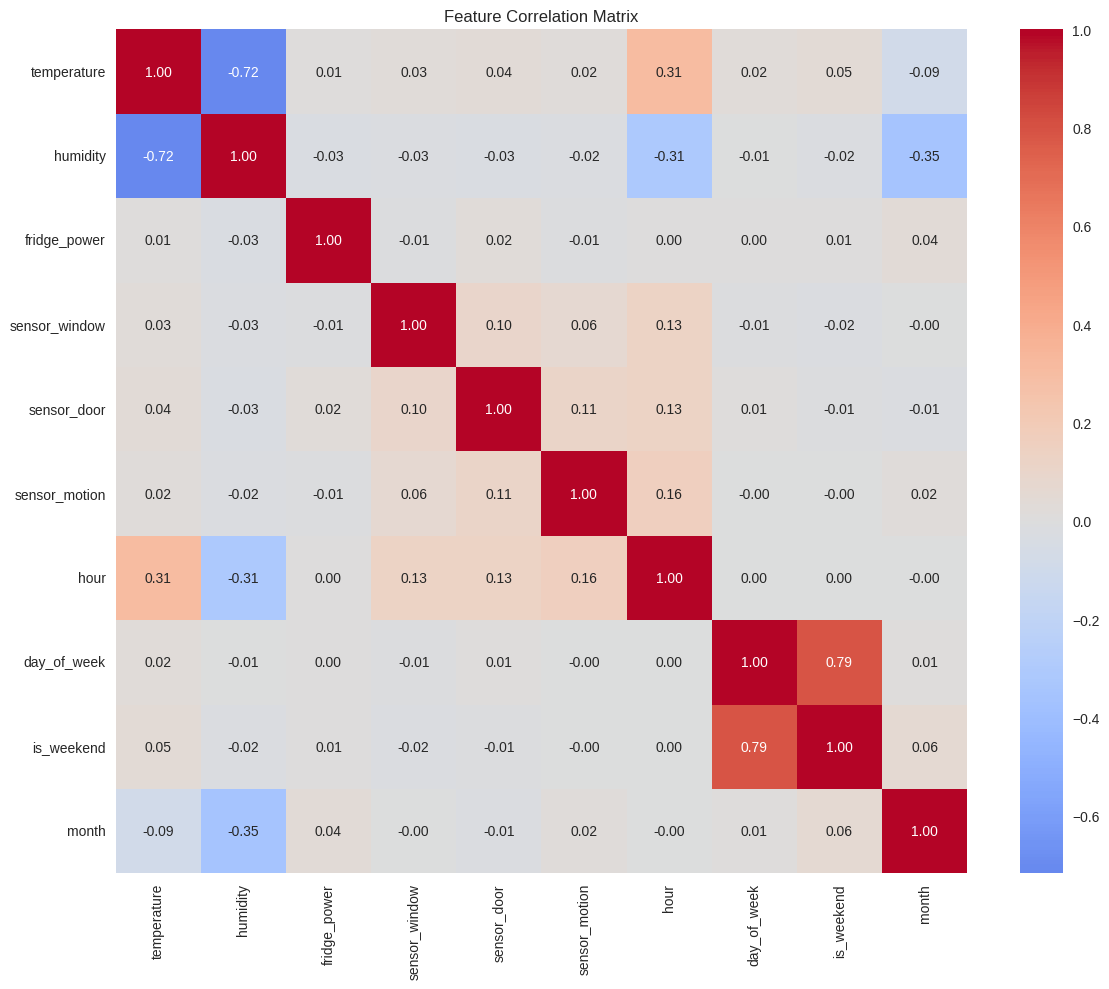

In [5]:
# Prepare features and labels
feature_cols = [col for col in available_sensors if col in df.columns]
print(f"Using features: {feature_cols}")

# Extract features and labels
X = df[feature_cols].copy()
y = df['is_anomaly'].values if 'is_anomaly' in df.columns else np.zeros(len(df))

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Anomaly distribution: {np.bincount(y.astype(int))}")

# Create time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['timestamp'].dt.month

# Add temporal features to X
temporal_features = ['hour', 'day_of_week', 'is_weekend', 'month']
for feature in temporal_features:
    X[feature] = df[feature]

print(f"Extended features: {list(X.columns)}")
print(f"Final feature matrix shape: {X.shape}")

# Display feature correlation matrix
print("\n=== FEATURE CORRELATION MATRIX ===")
correlation_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Statistical Baseline Methods

We'll start with simple statistical methods to establish a baseline for anomaly detection.

In [6]:
# Statistical anomaly detection functions
def detect_zscore_anomalies(data, threshold=3, window_size=24):
    """
    Detect anomalies using rolling z-score method.
    
    Args:
        data: Time series data
        threshold: Z-score threshold for anomaly detection
        window_size: Rolling window size for calculating mean and std
    """
    anomalies = pd.Series(False, index=data.index)
    
    # Calculate rolling statistics
    rolling_mean = data.rolling(window=window_size, min_periods=1).mean()
    rolling_std = data.rolling(window=window_size, min_periods=1).std()
    
    # Avoid division by zero
    rolling_std = rolling_std.fillna(1)
    rolling_std = rolling_std.replace(0, 1)
    
    # Calculate z-scores
    z_scores = np.abs((data - rolling_mean) / rolling_std)
    
    # Mark anomalies
    anomalies = z_scores > threshold
    
    return anomalies, z_scores

def detect_iqr_anomalies(data, window_size=48, k=1.5):
    """
    Detect anomalies using Interquartile Range (IQR) method.
    
    Args:
        data: Time series data
        window_size: Rolling window size for calculating IQR
        k: Multiplier for IQR range
    """
    anomalies = pd.Series(False, index=data.index)
    
    for i in range(len(data)):
        # Define window
        start = max(0, i - window_size + 1)
        window_data = data.iloc[start:i+1]
        
        if len(window_data) > 4:  # Need at least 5 points for IQR
            q1 = window_data.quantile(0.25)
            q3 = window_data.quantile(0.75)
            iqr = q3 - q1
            
            lower_bound = q1 - k * iqr
            upper_bound = q3 + k * iqr
            
            anomalies.iloc[i] = (data.iloc[i] < lower_bound) or (data.iloc[i] > upper_bound)
    
    return anomalies

def detect_moving_average_anomalies(data, window_size=24, threshold=2):
    """
    Detect anomalies using moving average deviation method.
    
    Args:
        data: Time series data
        window_size: Window size for moving average
        threshold: Multiplier for standard deviation threshold
    """
    # Calculate moving average and standard deviation
    moving_avg = data.rolling(window=window_size, min_periods=1).mean()
    moving_std = data.rolling(window=window_size, min_periods=1).std()
    
    # Calculate deviations
    deviations = np.abs(data - moving_avg)
    threshold_values = threshold * moving_std.fillna(1)
    
    # Mark anomalies
    anomalies = deviations > threshold_values
    
    return anomalies, deviations


In [7]:
# Separate continuous and binary features
continuous_features = ['temperature', 'humidity', 'fridge_power']
binary_features = ['sensor_window', 'sensor_door', 'sensor_motion']

statistical_results = {}

# Continuous sensors: rolling z-score, IQR, moving average
for sensor in continuous_features:
    if sensor in df.columns:
        print(f"\n=== Analyzing {sensor} (continuous) ===")
        zscore_anomalies, z_scores = detect_zscore_anomalies(df[sensor], threshold=2.5, window_size=60)
        iqr_anomalies = detect_iqr_anomalies(df[sensor])
        ma_anomalies, deviations = detect_moving_average_anomalies(df[sensor], window_size=60, threshold=3)
        statistical_results[sensor] = {
            'zscore_anomalies': zscore_anomalies,
            'z_scores': z_scores,
            'iqr_anomalies': iqr_anomalies,
            'ma_anomalies': ma_anomalies,
            'deviations': deviations
        }
        print(f"Z-Score anomalies: {zscore_anomalies.sum()}")
        print(f"IQR anomalies: {iqr_anomalies.sum()}")
        print(f"Moving Average anomalies: {ma_anomalies.sum()}")

# Binary sensors: rule-based anomaly detection (e.g., night-time activity)
def rule_based_binary(df, col, night_hours=(0, 5)):
    start, end = night_hours
    return ((df[col] == 1) & (df['hour'].between(start, end))).astype(bool)

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Ensure timestamp is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df

df = add_time_features(df)
for sensor in binary_features:
    if sensor in df.columns:
        print(f"\n=== Analyzing {sensor} (binary) ===")
        # Example: flag as anomaly if sensor is active during night hours
        anomalies = rule_based_binary(df, sensor, night_hours=(0, 5))
        statistical_results[sensor] = {
            'rule_based_anomalies': anomalies
        }
        print(f"Rule-based anomalies: {anomalies.sum()}")

print("\n=== Statistical Analysis Complete ===")
print(f"Processed {len(statistical_results)} sensors")


=== Analyzing temperature (continuous) ===
Z-Score anomalies: 90
IQR anomalies: 92
Moving Average anomalies: 36

=== Analyzing humidity (continuous) ===
Z-Score anomalies: 374
IQR anomalies: 360
Moving Average anomalies: 63

=== Analyzing fridge_power (continuous) ===
Z-Score anomalies: 32
IQR anomalies: 8558
Moving Average anomalies: 16

=== Analyzing sensor_window (binary) ===
Rule-based anomalies: 191

=== Analyzing sensor_door (binary) ===
Rule-based anomalies: 6

=== Analyzing sensor_motion (binary) ===
Rule-based anomalies: 97

=== Statistical Analysis Complete ===
Processed 6 sensors


In [8]:
# Statistical methods evaluation with ground truth
if 'is_anomaly' in df.columns and len(statistical_results) > 0:
    print(f"\n{'='*80}")
    print("📊 STATISTICAL METHODS EVALUATION WITH GROUND TRUTH")
    print(f"{'='*80}")
    
    # Store all statistical metrics
    stats_results = {}
    
    # Combine anomaly results across all sensors using OR logic (any sensor detecting anomaly)
    combined_zscore = pd.Series(False, index=df.index)
    combined_iqr = pd.Series(False, index=df.index)  
    combined_ma = pd.Series(False, index=df.index)
    
    for sensor, results in statistical_results.items():
        if 'zscore_anomalies' in results:
            combined_zscore |= results['zscore_anomalies']
        if 'iqr_anomalies' in results:
            combined_iqr |= results['iqr_anomalies']
        if 'ma_anomalies' in results:
            combined_ma |= results['ma_anomalies']
    
    # Get ground truth
    y_true = df['is_anomaly'].values
    
    # 1. Z-Score Method Evaluation
    z_metrics = calculate_comprehensive_metrics(
        y_true, combined_zscore.astype(int).values, 
        "Z-Score (Combined Sensors)", print_results=True
    )
    
    # 2. IQR Method Evaluation  
    iqr_metrics = calculate_comprehensive_metrics(
        y_true, combined_iqr.astype(int).values,
        "IQR (Combined Sensors)", print_results=True
    )
    
    # 3. Moving Average Method Evaluation
    ma_metrics = calculate_comprehensive_metrics(
        y_true, combined_ma.astype(int).values,
        "Moving Average (Combined Sensors)", print_results=True
    )
    
    # Store results for later comparison
    stats_results = {
        'zscore': z_metrics,
        'iqr': iqr_metrics, 
        'moving_average': ma_metrics
    }
    
    # Create comparison table for statistical methods
    stats_comparison = pd.DataFrame({
        'Method': ['Z-Score', 'IQR', 'Moving Average'],
        'Accuracy': [z_metrics['accuracy'], iqr_metrics['accuracy'], ma_metrics['accuracy']],
        'Precision': [z_metrics['precision'], iqr_metrics['precision'], ma_metrics['precision']],
        'Recall': [z_metrics['recall'], iqr_metrics['recall'], ma_metrics['recall']],
        'F1-Score': [z_metrics['f1_score'], iqr_metrics['f1_score'], ma_metrics['f1_score']],
        'Detected_Anomalies': [combined_zscore.sum(), combined_iqr.sum(), combined_ma.sum()],
        'True_Positives': [z_metrics['true_positives'], iqr_metrics['true_positives'], ma_metrics['true_positives']],
        'False_Positives': [z_metrics['false_positives'], iqr_metrics['false_positives'], ma_metrics['false_positives']],
        'False_Negatives': [z_metrics['false_negatives'], iqr_metrics['false_negatives'], ma_metrics['false_negatives']]
    })
    
    print(f"\n📋 STATISTICAL METHODS COMPARISON:")
    print(stats_comparison.round(4))
    
    # Find best statistical method
    best_f1_idx = stats_comparison['F1-Score'].idxmax()
    best_method = stats_comparison.loc[best_f1_idx]
    print(f"\n🏆 BEST STATISTICAL METHOD: {best_method['Method']} (F1-Score: {best_method['F1-Score']:.4f})")
    
else:
    print("⚠️  Ground truth labels not available - skipping statistical methods evaluation")
    stats_results = None


📊 STATISTICAL METHODS EVALUATION WITH GROUND TRUTH

📊 COMPREHENSIVE METRICS - Z-SCORE (COMBINED SENSORS)

🔢 CONFUSION MATRIX:
                 Predicted
               Normal  Anomaly
Actual Normal    125084      359
     Anomaly       4026      131

📈 KEY METRICS:
  Accuracy:     0.9662 (96.62%)
  Precision:    0.2673 (26.73%)
  Recall:       0.0315 (3.15%)
  F1-Score:     0.0564
  Specificity:  0.9971 (99.71%)

🔍 DETAILED BREAKDOWN:
  True Positives:    131 (Correctly detected anomalies)
  True Negatives:  125084 (Correctly detected normal)
  False Positives:   359 (False alarms)
  False Negatives:  4026 (Missed anomalies)
  False Positive Rate: 0.0029 (0.29%)
  False Negative Rate: 0.9685 (96.85%)

📊 COMPREHENSIVE METRICS - IQR (COMBINED SENSORS)

🔢 CONFUSION MATRIX:
                 Predicted
               Normal  Anomaly
Actual Normal    116896     8547
     Anomaly       3727      430

📈 KEY METRICS:
  Accuracy:     0.9053 (90.53%)
  Precision:    0.0479 (4.79%)
  Recall:      

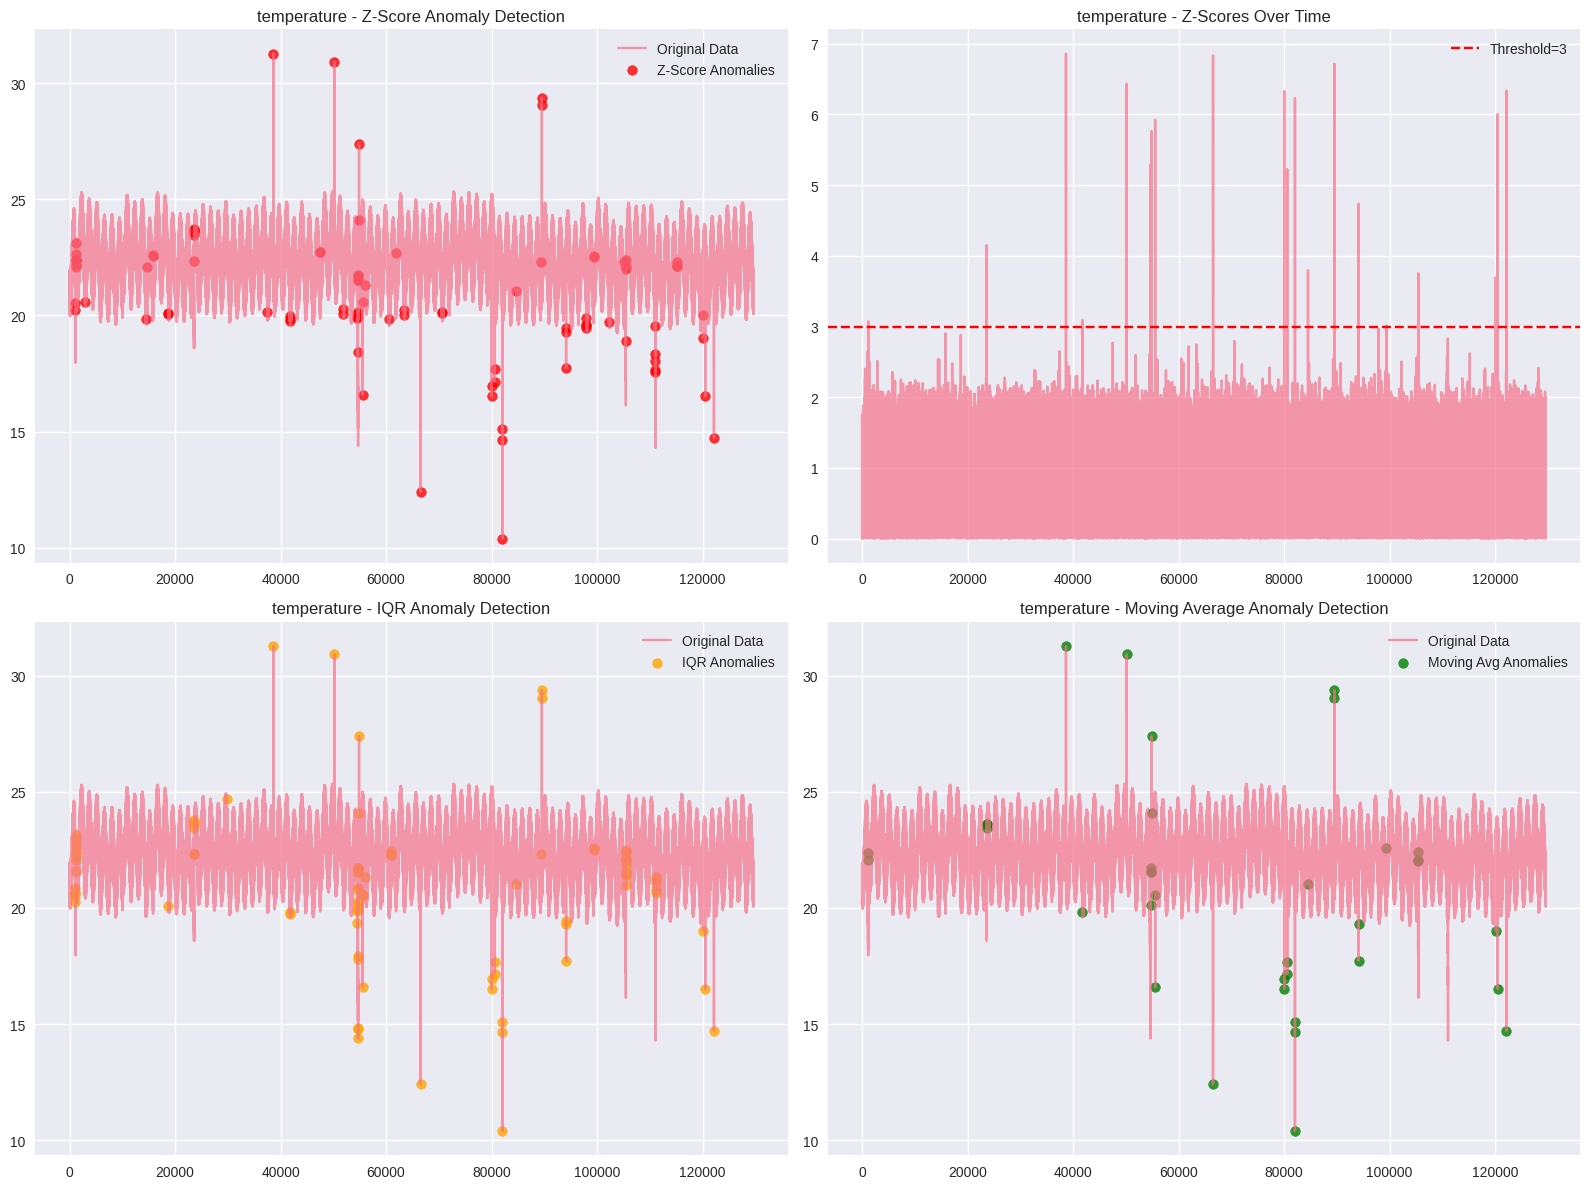


=== temperature Statistical Summary ===
Total data points: 129600
Z-Score anomalies: 90
IQR anomalies: 92
Moving Average anomalies: 36
True anomalies (ground truth): 4157


In [9]:
# Visualize statistical results for a sample sensor
sample_sensor = feature_cols[0]  # Use first available sensor
if sample_sensor in statistical_results:
    results = statistical_results[sample_sensor]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Original data with anomalies
    axes[0, 0].plot(df.index, df[sample_sensor], alpha=0.7, label='Original Data')
    zscore_idx = results['zscore_anomalies'][results['zscore_anomalies']].index
    axes[0, 0].scatter(zscore_idx, df.loc[zscore_idx, sample_sensor], 
                      color='red', alpha=0.8, s=50, label='Z-Score Anomalies')
    axes[0, 0].set_title(f'{sample_sensor} - Z-Score Anomaly Detection')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Z-scores over time
    axes[0, 1].plot(df.index, results['z_scores'], alpha=0.7)
    axes[0, 1].axhline(y=3, color='red', linestyle='--', label='Threshold=3')
    axes[0, 1].set_title(f'{sample_sensor} - Z-Scores Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # IQR anomalies
    axes[1, 0].plot(df.index, df[sample_sensor], alpha=0.7, label='Original Data')
    iqr_idx = results['iqr_anomalies'][results['iqr_anomalies']].index
    axes[1, 0].scatter(iqr_idx, df.loc[iqr_idx, sample_sensor], 
                      color='orange', alpha=0.8, s=50, label='IQR Anomalies')
    axes[1, 0].set_title(f'{sample_sensor} - IQR Anomaly Detection')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Moving average anomalies
    axes[1, 1].plot(df.index, df[sample_sensor], alpha=0.7, label='Original Data')
    ma_idx = results['ma_anomalies'][results['ma_anomalies']].index
    axes[1, 1].scatter(ma_idx, df.loc[ma_idx, sample_sensor], 
                      color='green', alpha=0.8, s=50, label='Moving Avg Anomalies')
    axes[1, 1].set_title(f'{sample_sensor} - Moving Average Anomaly Detection')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n=== {sample_sensor} Statistical Summary ===")
    print(f"Total data points: {len(df)}")
    print(f"Z-Score anomalies: {results['zscore_anomalies'].sum()}")
    print(f"IQR anomalies: {results['iqr_anomalies'].sum()}")
    print(f"Moving Average anomalies: {results['ma_anomalies'].sum()}")
    
    if 'is_anomaly' in df.columns:
        true_anomalies = df['is_anomaly'].sum()
        print(f"True anomalies (ground truth): {true_anomalies}")
else:
    print("No statistical results available for visualization")

# Deep Learning Approach: LSTM Autoencoder



In [10]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict

# -----------------------
# Feature groups
# -----------------------
CONTINUOUS_FEATURES = ['temperature','humidity','fridge_power']
BINARY_FEATURES = ['sensor_window','sensor_door','sensor_motion']
FEATURES = CONTINUOUS_FEATURES + BINARY_FEATURES

SEQ_LEN_CONT = 180   # continuous LSTM sequence length
SEQ_LEN_BIN = 60    # binary LSTM sequence length
STRIDE = 1
BATCH_SIZE = 256
HIDDEN = 128
LATENT = 32
NUM_LAYERS = 2
DROPOUT = 0.1
LR = 1e-3
EPOCHS = 20
PATIENCE = 5
THRESHOLD_PERCENTILE = 99.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Dataset
# -----------------------
class SequenceDataset(Dataset):
    def __init__(self, data_df, features, seq_len=60, stride=1, labels_df=None, label_col=None):
        self.features = features
        self.seq_len = seq_len
        X = data_df[features].values
        self.seqs = [X[i:i+seq_len] for i in range(0, len(X)-seq_len+1, stride)]
        self.labels = None
        if labels_df is not None and label_col in labels_df.columns:
            y = labels_df[label_col].astype(int).values
            self.labels = [y[i:i+seq_len] for i in range(0, len(X)-seq_len+1, stride)]
    
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.seqs[idx], dtype=torch.float32)
        if self.labels is not None:
            y = torch.tensor(self.labels[idx], dtype=torch.long)
            return x, y
        return x


In [11]:
# ========= Feature groups =========
# Separate continuous vs binary features for tailored treatment
CONTINUOUS_FEATURES = ['temperature', 'humidity', 'fridge_power']
BINARY_FEATURES = ['sensor_window', 'sensor_door', 'sensor_motion']
FEATURES = CONTINUOUS_FEATURES + BINARY_FEATURES

# ========= Model =========
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_size=64, latent_size=16, num_layers=2, dropout=0.1):
        super().__init__()
        self.encoder_lstm = nn.LSTM(n_features, hidden_size, num_layers=num_layers,
                                    batch_first=True, dropout=dropout)
        self.fc_enc = nn.Linear(hidden_size, latent_size)
        self.fc_dec = nn.Linear(latent_size, hidden_size)
        self.decoder_lstm = nn.LSTM(n_features, hidden_size, num_layers=num_layers,
                                    batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(hidden_size, n_features)
    
    def forward(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        z = self.fc_enc(h_n[-1])
        dec_h0 = torch.tanh(self.fc_dec(z)).unsqueeze(0).repeat(self.decoder_lstm.num_layers, 1, 1)
        dec_c0 = torch.zeros_like(dec_h0)
        dec_out, _ = self.decoder_lstm(x, (dec_h0, dec_c0))
        return self.output_layer(dec_out)

# ========= Custom loss =========
def mixed_loss(y_pred, y_true):
    """
    Continuous features → Mean Squared Error (MSE)
    Binary features     → Binary Cross-Entropy (BCE)
    """
    loss = 0.0
    
    # Continuous part
    if CONTINUOUS_FEATURES:
        mse = torch.mean((y_pred[..., :len(CONTINUOUS_FEATURES)] - 
                          y_true[..., :len(CONTINUOUS_FEATURES)]) ** 2)
        loss += mse
    
    # Binary part
    if BINARY_FEATURES:
        # Apply sigmoid before BCE
        logits = y_pred[..., len(CONTINUOUS_FEATURES):]
        target = y_true[..., len(CONTINUOUS_FEATURES):]
        bce = nn.BCEWithLogitsLoss()(logits, target)
        loss += bce
    
    return loss

# ========= Training =========
def train_model(model, train_loader, val_loader=None, epochs=30, lr=1e-3, patience=5):
    model = model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=lr)
    best_val, best_state, wait = float("inf"), None, 0
    
    for epoch in range(1, epochs+1):
        model.train()
        total = 0
        for batch in train_loader:
            x = batch[0].to(DEVICE) if isinstance(batch, (list, tuple)) else batch.to(DEVICE)
            opt.zero_grad()
            recon = model(x)
            loss = mixed_loss(recon, x)   # <<< use mixed loss here
            loss.backward()
            opt.step()
            total += loss.item() * x.size(0)
        train_loss = total / len(train_loader.dataset)
        print(f"Epoch {epoch}/{epochs} — train_loss: {train_loss:.6f}")
        
        if val_loader:
            model.eval()
            vtotal = 0
            with torch.no_grad():
                for vb in val_loader:
                    vx = vb[0].to(DEVICE) if isinstance(vb, (list, tuple)) else vb.to(DEVICE)
                    vtotal += mixed_loss(model(vx), vx).item() * vx.size(0)
            val_loss = vtotal / len(val_loader.dataset)
            print(f"   val_loss: {val_loss:.6f}")
            if val_loss < best_val:
                best_val, best_state, wait = val_loss, model.state_dict(), 0
            else:
                wait += 1
            if wait >= patience: break
    if best_state: model.load_state_dict(best_state)
    return model

# ========= Compute per-feature errors =========
def per_feature_errors(model, dataset):
    """
    Compute reconstruction errors per feature (continuous: MSE, binary: BCE).
    Returns dict of {feature: errors}.
    """
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    errors = {feat: [] for feat in FEATURES}
    with torch.no_grad():
        for b in loader:
            if isinstance(b, (list, tuple)): x, _ = b
            else: x = b
            x = x.to(DEVICE)
            recon = model(x)
            
            # Continuous errors
            if CONTINUOUS_FEATURES:
                diff = (recon[..., :len(CONTINUOUS_FEATURES)] - 
                        x[..., :len(CONTINUOUS_FEATURES)]) ** 2
                for i, feat in enumerate(CONTINUOUS_FEATURES):
                    errors[feat].extend(diff[..., i].mean(dim=1).cpu().numpy())
            
            # Binary errors (use sigmoid + BCE)
            if BINARY_FEATURES:
                logits = recon[..., len(CONTINUOUS_FEATURES):]
                target = x[..., len(CONTINUOUS_FEATURES):]
                probs = torch.sigmoid(logits)
                bce = -(target * torch.log(probs + 1e-8) + (1-target)*torch.log(1-probs + 1e-8))
                for j, feat in enumerate(BINARY_FEATURES):
                    errors[feat].extend(bce[..., j].mean(dim=1).cpu().numpy())
    return {k: np.array(v) for k, v in errors.items()}

# ========= Train + per-feature thresholds =========
if df_normal is not None:
    scaler = StandardScaler().fit(df_normal[CONTINUOUS_FEATURES])  # scale only continuous
    df_normal_scaled = df_normal.copy()
    df_normal_scaled[CONTINUOUS_FEATURES] = scaler.transform(df_normal[CONTINUOUS_FEATURES])
    
    train_ds = SequenceDataset(df_normal_scaled, FEATURES, SEQ_LEN_CONT, STRIDE)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    model = LSTMAutoencoder(len(FEATURES), HIDDEN, LATENT, NUM_LAYERS, DROPOUT)
    model = train_model(model, train_loader, epochs=EPOCHS, lr=LR, patience=PATIENCE)
    
    # === Compute per-feature thresholds ===
    train_errs = per_feature_errors(model, train_ds)
    thresholds = {feat: np.percentile(errs, THRESHOLD_PERCENTILE) 
                  for feat, errs in train_errs.items()}
    print("\nPer-feature thresholds:")
    for feat, th in thresholds.items():
        print(f" {feat}: {th:.6f}")


Epoch 1/20 — train_loss: 0.080747
Epoch 2/20 — train_loss: 0.002692
Epoch 3/20 — train_loss: 0.001717
Epoch 4/20 — train_loss: 0.001259
Epoch 5/20 — train_loss: 0.001002
Epoch 6/20 — train_loss: 0.000821
Epoch 7/20 — train_loss: 0.000718
Epoch 8/20 — train_loss: 0.000630
Epoch 9/20 — train_loss: 0.000567
Epoch 10/20 — train_loss: 0.000514
Epoch 11/20 — train_loss: 0.000465
Epoch 12/20 — train_loss: 0.000434
Epoch 13/20 — train_loss: 0.000395
Epoch 14/20 — train_loss: 0.000374
Epoch 15/20 — train_loss: 0.000347
Epoch 16/20 — train_loss: 0.000326
Epoch 17/20 — train_loss: 0.000307
Epoch 18/20 — train_loss: 0.000287
Epoch 19/20 — train_loss: 0.000268
Epoch 20/20 — train_loss: 0.000254

Per-feature thresholds:
 temperature: 0.000626
 humidity: 0.000461
 fridge_power: 0.000168
 sensor_window: 0.000001
 sensor_door: 0.000002
 sensor_motion: 0.000002


In [12]:
from collections import defaultdict

def evaluate_per_feature(df, name, model, scaler, thresholds, seq_len=SEQ_LEN_CONT, stride=STRIDE):
    """
    Evaluate each feature using its own threshold.
    df         : DataFrame with features + ground truth anomaly columns.
    model      : trained LSTM autoencoder
    scaler     : StandardScaler for continuous features
    thresholds : dict {feature: threshold_value}
    """
    if df is None:
        return
    
    df_scaled = df.copy()
    # Scale only continuous features
    df_scaled[CONTINUOUS_FEATURES] = scaler.transform(df[CONTINUOUS_FEATURES])
    
    results = defaultdict(dict)

    for feat in FEATURES:
        label_col = f"is_anomaly_{feat}"
        if label_col not in df.columns:
            print(f"⚠ {label_col} missing in {name}, skipping...")
            continue

        # Build dataset with labels for this feature
        ds = SequenceDataset(df_scaled, FEATURES, seq_len, stride, labels_df=df, label_col=label_col)
        # Compute per-sequence reconstruction errors for this feature
        errs_dict = per_feature_errors(model, ds)
        errs = errs_dict[feat]  # select only this feature
        labs = []
        # Build sequence-level labels (aggregate: any anomaly in sequence → anomaly)
        for i in range(len(ds)):
            _, y = ds[i]
            labs.append(y.max().item())  # 1 if any anomaly in sequence, else 0
        labs = np.array(labs)

        # Predict anomaly if error > threshold for this feature
        preds = (errs > thresholds[feat]).astype(int)
        
        # Compute metrics
        prec = precision_score(labs, preds, zero_division=0)
        rec  = recall_score(labs, preds, zero_division=0)
        f1   = f1_score(labs, preds, zero_division=0)
        cm   = confusion_matrix(labs, preds)

        results[feat] = {
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "confusion_matrix": cm
        }

    # Print nicely
    print(f"\n{name} — Per-feature evaluation using per-feature thresholds:")
    for feat, metrics in results.items():
        print(f"\nFeature: {feat}")
        print(f" Precision: {metrics['precision']:.3f}")
        print(f" Recall:    {metrics['recall']:.3f}")
        print(f" F1:        {metrics['f1']:.3f}")
        print(f" Confusion matrix:\n{metrics['confusion_matrix']}")

# ==========================
# Run evaluation
# ==========================
evaluate_per_feature(df_basic, "Basic anomalies", model, scaler, thresholds)
evaluate_per_feature(df_realistic, "Realistic anomalies", model, scaler, thresholds)



Basic anomalies — Per-feature evaluation using per-feature thresholds:

Feature: temperature
 Precision: 0.634
 Recall:    1.000
 F1:        0.776
 Confusion matrix:
[[122170   2654]
 [     0   4597]]

Feature: humidity
 Precision: 0.295
 Recall:    1.000
 F1:        0.456
 Confusion matrix:
[[121493   5589]
 [     0   2339]]

Feature: fridge_power
 Precision: 0.198
 Recall:    0.952
 F1:        0.328
 Confusion matrix:
[[120833   6816]
 [    85   1687]]

Feature: sensor_window
 Precision: 0.009
 Recall:    0.075
 F1:        0.016
 Confusion matrix:
[[120143   8282]
 [   921     75]]

Feature: sensor_door
 Precision: 0.021
 Recall:    0.219
 F1:        0.038
 Confusion matrix:
[[120732   7914]
 [   605    170]]

Feature: sensor_motion
 Precision: 0.021
 Recall:    0.127
 F1:        0.036
 Confusion matrix:
[[120459   7688]
 [  1112    162]]

Realistic anomalies — Per-feature evaluation using per-feature thresholds:

Feature: temperature
 Precision: 0.556
 Recall:    0.842
 F1:        